In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import shutil
import random
import time
import json
import keras.backend as K
from keras import regularizers
import matplotlib.font_manager
# keep

#Set latex font
# plt.rcParams.update({'font.-family': 'Serif','font.serif': 'CMU Serif', 'font.size': 14})

WIRE_ANTENNA = True

VERIFY_TEST_SET = False
PLOT_TRAIN = True
PLOT_TEST = True
PLOT_TEST_LOSS = True
MAX_LAYERS = 4

def load_data(path: str):
    """
    This function loads data from a pickle file located at the provided path.

    Parameters:
        path (str): The path to the pickle file.

    Returns:
        par_comb (np.ndarray): The parameter combinations.
        S11_par (np.ndarray): The best parametric data.
        frequency (np.ndarray): The frequency data.
        degrees (np.ndarray): The degrees data.
        combined_gain (np.ndarray): The combined gain list.
        std_dev (np.ndarray): The standard deviation of Phi.
        efficiency (np.ndarray): The efficiency data.
    """

    with open(path,'rb') as file:
        data_dict = pickle.load(file)
    print(f"Dictionary keys: {data_dict.keys()}")

    par_comb = np.asarray(data_dict['Parameter combination'])
    S11_vals = np.asarray(data_dict['S1,1'])
    frequency = np.asarray(data_dict['Frequency'])
    # S11_parametrized = np.asarray(data_dict['Parametric S1,1'])
    degrees = np.asarray(data_dict['degrees'])
    combined_gain = np.asarray(data_dict['combined gain list'])
    std_dev = np.asarray(data_dict['Standard deviation Phi'])
    efficiency = np.asarray(data_dict['efficiency'])
    #efficiency = np.asarray(list(data_dict['efficiency'].values()))
    return par_comb, S11_vals, frequency, degrees, combined_gain, std_dev, efficiency


def normalize_data(data_input, mean, std_dev, inverse: bool):
    if inverse:
        data = data_input*std_dev + mean
    else:   
        mean = mean
        std = std_dev
        data = (data_input-mean)/std
    return data

def weighted_mse(y_true, y_pred):
    #Pass y_true values through a sigmoid function
    weights = 2* K.sigmoid(-y_true)+2

    return K.mean(weights * K.square(y_pred - y_true), axis=-1)



# Run main code
if __name__ == "__main__":
    run_times = []
    start_time = time.perf_counter()
    path = 'C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning/'
    if WIRE_ANTENNA:
        par_comb, S11_vals, frequency, degrees, combined_gain, std_dev, efficiency = load_data(f"C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning/data/Wire_results/simple_wire2_final_with_parametric.pkl")
    else:
        par_comb, S11_vals, frequency, degrees, combined_gain, std_dev, efficiency = load_data(f"C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning/data/MIFA_results/MIFA_results.pkl")


    # # Normalize data
    # par_comb_norm = normalize_data(par_comb,np.mean(par_comb),np.std(par_comb), False)
    # S11_vals_norm = normalize_data(S11_vals,np.mean(S11_vals),np.std(S11_vals), False)
    # # S11_parameterized_norm = normalize_data(S11_parameterized, np.mean(S11_parameterized),np.std(S11_parameterized), False)
    # frequency_norm = normalize_data(frequency, np.mean(frequency),np.std(frequency), False)
    # degrees_norm = normalize_data(degrees, np.mean(degrees),np.std(degrees), False)
    # combined_gain_norm = normalize_data(combined_gain, np.mean(combined_gain),np.std(combined_gain), False)
    # std_dev_norm = normalize_data(std_dev, np.mean(std_dev),np.std(std_dev), False)
    # efficiency_norm = normalize_data(efficiency, np.mean(efficiency),np.std(efficiency), False)


    input_vector = par_comb

    output_vector = np.asarray([np.concatenate((S11_vals[i], [std_dev[i]], [efficiency[i]]))for i in range(S11_vals.shape[0])])


    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(input_vector, output_vector, test_size=0.3, shuffle=True, random_state=42)

    x_train_norm = normalize_data(x_train, np.mean(x_train),np.std(x_train), False)
    x_test_norm = normalize_data(x_test, np.mean(x_test),np.std(x_test), False)
    y_train_norm = normalize_data(y_train, np.mean(y_train),np.std(y_train), False)
    y_test_norm = normalize_data(y_test, np.mean(y_test),np.std(y_test), False)



    std_dev = y_test[:,-2]
    efficiency = y_test[:,-1]

    if VERIFY_TEST_SET:
        # Find test curves where the S11 goes below -10 dB and the frequency is below 2 GHz
        test_indices = []
        for idx, i in enumerate(normalize_data(y_test[:,:1001],np.mean(S11_vals),np.std(S11_vals), True)):
            if np.min(i) < -10 and frequency[np.argmin(i)] < 2000:
                test_indices.append(idx)
        print(f"Number of test curves that satisfy the condition: {len(test_indices)} within the test set")

        # Select 10 random curves from the good test curves
        random_indices = random.sample(test_indices, 10)

        # plot random test data curves to verify that a good solution is within the test set
        plt.figure(figsize=(50, 50))
        for idx, i in enumerate(random_indices):
            plt.subplot(5, 2, idx+1)
            plt.plot(frequency, normalize_data(y_test[i][0:1001],np.mean(S11_vals),np.std(S11_vals),True), label='test')
            plt.legend()
            plt.grid(True)
            plt.ylim([-40,2])
        plt.show()
        
    # Make a 6 layer neural network using relu activation functions
    model = keras.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)) )
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    # model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(y_train.shape[1], activation='linear'))

    # Create lists to store the results
    loss_train = []
    mean_error_train = []
    mean_error_pred = np.zeros(50)

    model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=weighted_mse,
                metrics=[keras.metrics.MeanSquaredError()]
            )
    model.summary()


    # Train the model
    history = model.fit(x_train_norm,
                        y_train_norm,
                        epochs=500,
                        batch_size=100,
                        shuffle=True,
                        verbose=1)

    # Define the loss and accuracy for the training and test data
    loss_train.extend(model.history.history['loss'])
    mean_error_train.extend(model.history.history['mean_squared_error']) 
            

Dictionary keys: dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'degrees', 'combined gain list', 'Standard deviation Phi', 'efficiency', 'Parametric S1,1'])
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)     

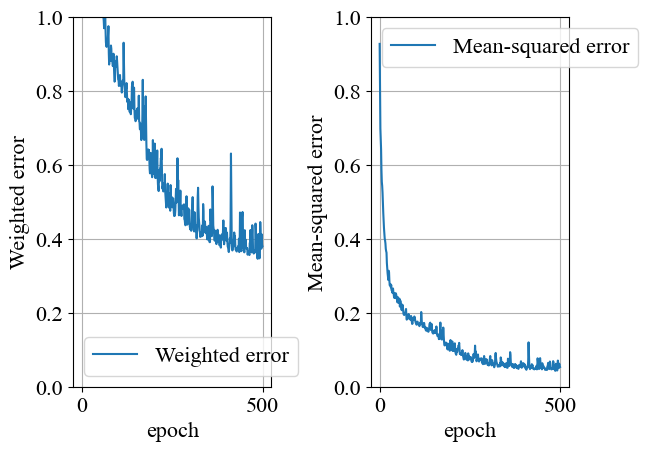

24/24 [==============================] - 0s 1ms/step
Number of test curves that satisfy the condition: 110 within the test set
[146, 118, 184, 209]
MSE_std_dev: 0.17352208809052352, MSE_efficiency: 0.757351313407692


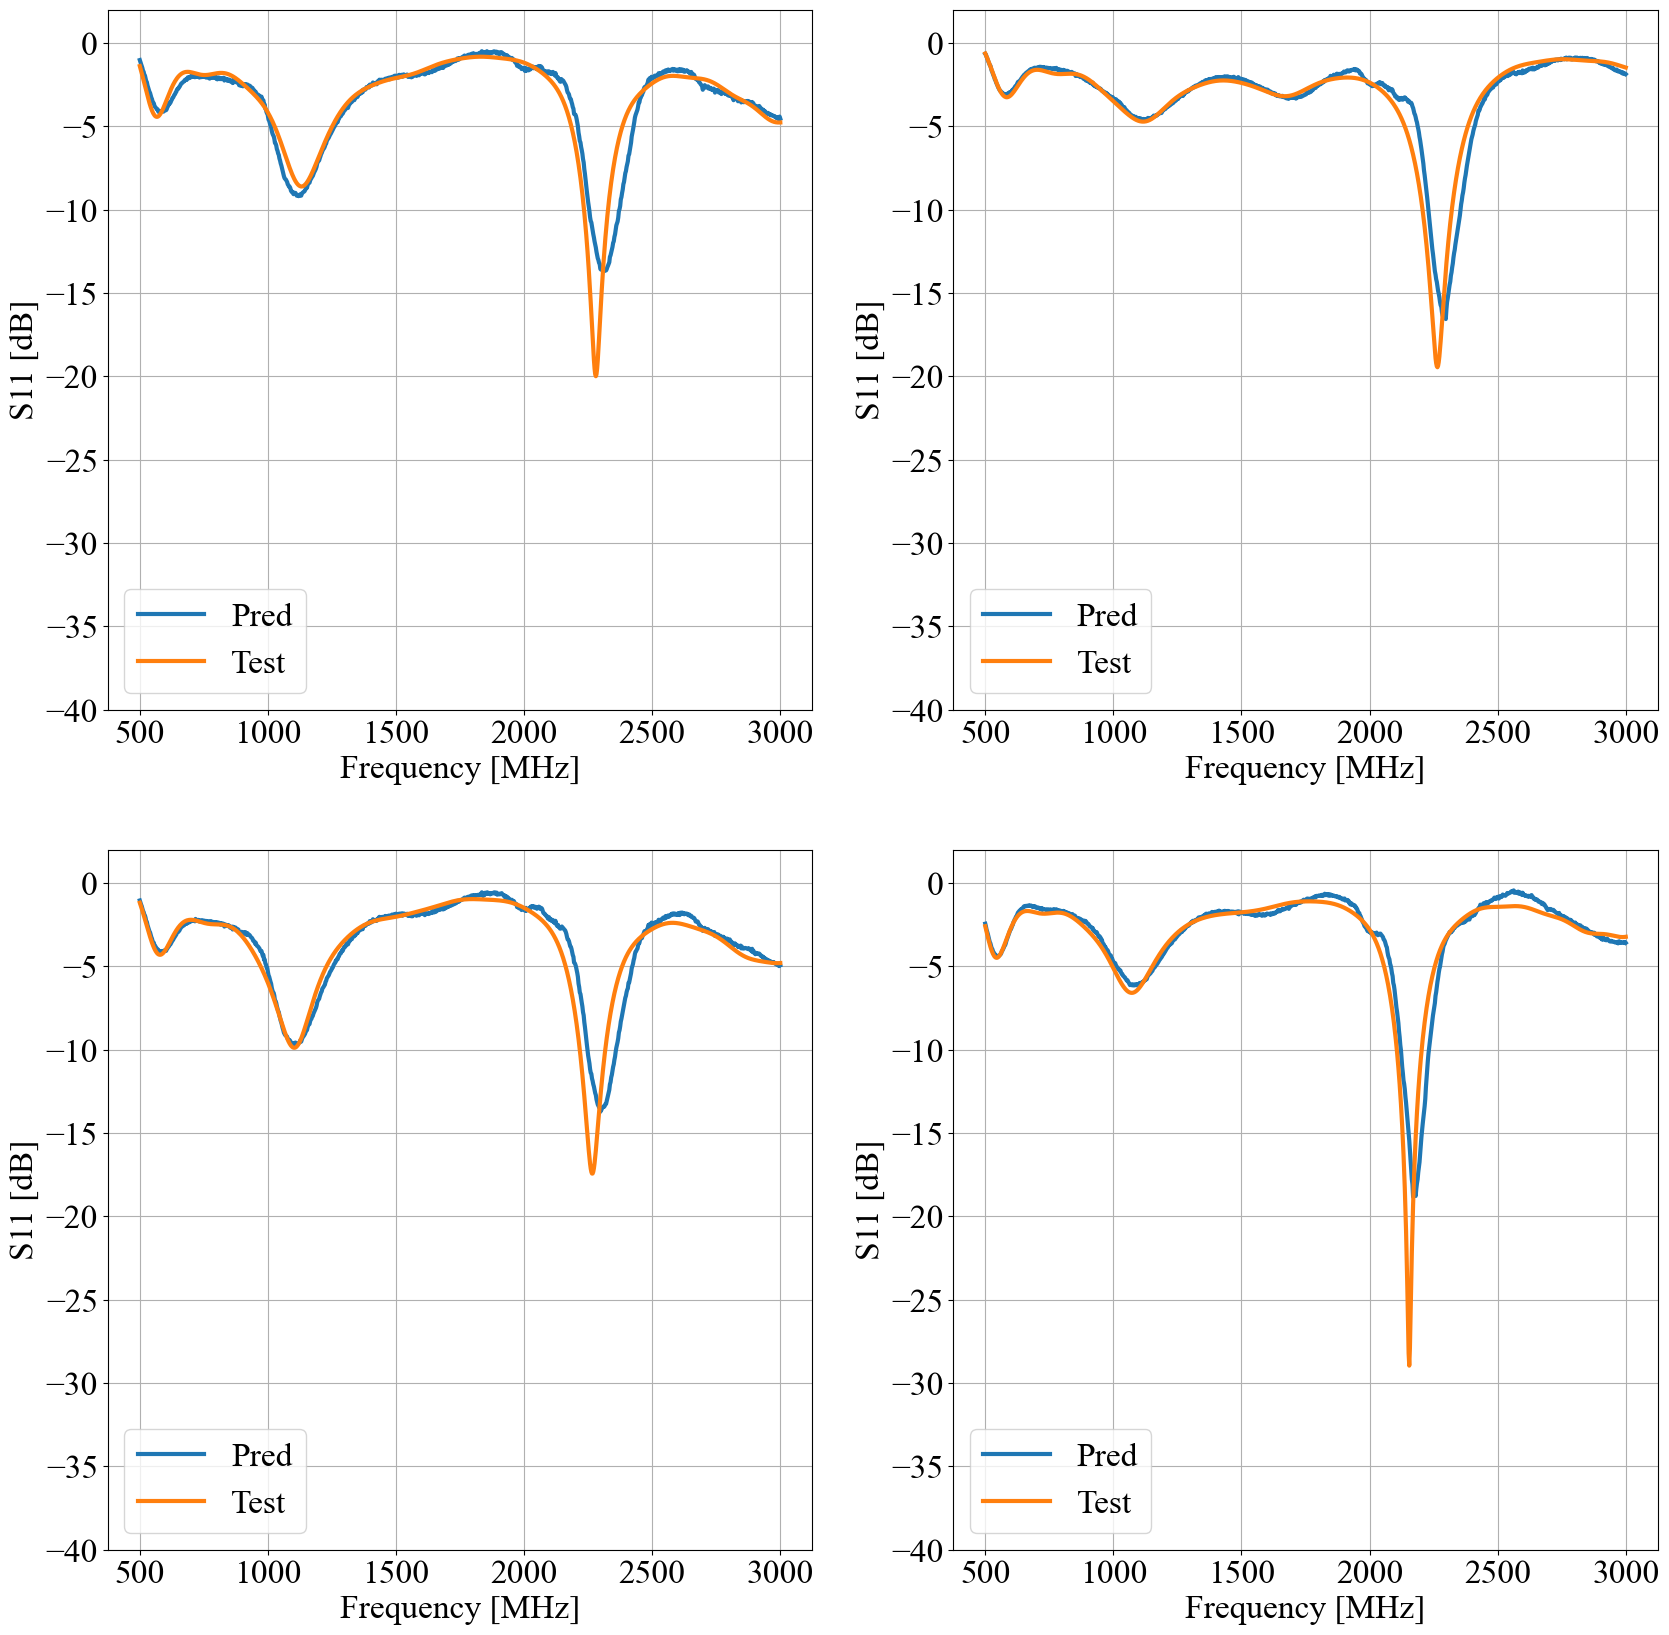

Test loss: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [3]:
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman'], 'font.size': 16})      

if PLOT_TRAIN:
    plt.figure()
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(121)
    plt.grid(True)
    plt.plot(np.array(loss_train).T)
    plt.ylabel('Weighted error')
    plt.xlabel('epoch')
    plt.legend(['Weighted error'])
    plt.ylim([0, 1])
    plt.subplot(122)
    plt.grid(True)
    plt.plot(np.array(mean_error_train).T)
    plt.ylabel('Mean-squared error')
    plt.xlabel('epoch')
    plt.legend(['Mean-squared error'])
    plt.ylim([0, 1])
    
    if WIRE_ANTENNA:
        # For saving the training loss figure for Wire
        train_loss_path = os.path.join(path, 'data', 'Wire_results',f'train_loss_with_regularizer.pdf').replace("\\", "/")
    else:   
        # For saving the training loss figure for MIFA
        train_loss_path = os.path.join(path, 'data', 'MIFA_results',f'train_loss_with_regularizer.pdf').replace("\\", "/")
    # plt.show()
    plt.savefig(train_loss_path, format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()
    
# Run the model on the test data and get the loss and mean-squared error
y_pred_norm = model.predict(x_test_norm)
# _ , mean_error_pred = model.evaluate(X_test, y_test)

    # Reverse the normalization of the data individually
y_pred = normalize_data(y_pred_norm, np.mean(y_train),np.std(y_train), inverse=True) 

# #Split the data into separate performancem metrics
# y_pred_s11 = y_pred[:][:1001]
# std_dev_pred = y_pred[:,-2]
# efficiency_pred = y_pred[:,-1]

# y_pred_s11 = normalize_data(y_pred_norm[:,:1001], np.mean(S11_vals),np.std(S11_vals), inverse=True)
# std_dev_pred = normalize_data(y_pred_norm[:,-2], np.mean(std_dev), np.std(std_dev), inverse=True)
# efficiency_pred = normalize_data(y_pred_norm[:,-1], np.mean(efficiency), np.std(std_dev), inverse=True)

# #Compute MSE of predicted S11 curve and test s11 curve
# MSE = mean_squared_error(y_pred_s11, y_test[:,:1001])
# print(f'Test MSE: {MSE}')
# Find test curves where the S11 goes below -10 dB and the frequency is below 2 GHz
test_indices = []
for idx, i in enumerate(y_test[:,:1001]):
    if np.min(i) < -10 and frequency[np.argmin(i)] in range(1500,2500):
        test_indices.append(idx)
print(f"Number of test curves that satisfy the condition: {len(test_indices)} within the test set")

# Select 10 random curves from the good test curves
random_indices = random.sample(test_indices, 4)
print(random_indices)

random_indices = [329, 690, 439, 19] # Wire indices
# random_indices = [80, 877, 906, 462] #MIFA indices


error_std_dev = np.abs(std_dev - y_pred[:,-2])
MSE_std_dev = mean_squared_error(std_dev, y_pred[:,-2])

error_efficiency = np.abs(efficiency - y_pred[:,-1])
MSE_efficiency = mean_squared_error(efficiency, y_pred[:,-1])


error_dictionary = {'error_std_dev': error_std_dev.tolist(), 'MSE_std_dev': MSE_std_dev.tolist(), 'error_efficiency': error_efficiency.tolist(), 'MSE_efficiency': MSE_efficiency.tolist()}
print(f'MSE_std_dev: {error_dictionary["MSE_std_dev"]}, MSE_efficiency: {error_dictionary["MSE_efficiency"]}')


# with open (f'{path}/data/DNN_results/relu/error_std_eff.txt', 'w') as file:
#     file.write(json.dumps(error_dictionary)) 

# Plot the test data and the predicted data
if PLOT_TEST: 
    plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman'], 'font.size': 24})      
    plt.figure(figsize=(20, 20))
    for idx, i in enumerate(random_indices):
        plt.subplot(2, 2, idx+1)
        plt.plot(frequency, y_pred[i][:1001],linewidth = 3, label='Pred')
        plt.plot(frequency, y_test[i][:1001],linewidth = 3, label='Test')
        plt.legend()
        plt.grid(True)
        plt.ylim([-40,2])
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('S11 [dB]')
    if WIRE_ANTENNA:
        # For saving the testing prediction figure
        test_pred_path = os.path.join(path, 'data', 'Wire_results', f'test_pred_with_regularizer.pdf').replace("\\", "/")
    else:
        # For saving the testing prediction figure
        test_pred_path = os.path.join(path, 'data', 'MIFA_results', f'test_pred_with_regularizer.pdf').replace("\\", "/")
    plt.savefig(test_pred_path, format="pdf", bbox_inches="tight")   
    plt.show()
    plt.close()
        
    # Save the model
    if WIRE_ANTENNA:
        # For saving the model for Wire
        model_path = os.path.join(path, 'data', 'Wire_results', 'Forward_model_wire.keras').replace("\\", "/")

    else:
        model_path = os.path.join(path, 'data', 'MIFA_results', 'Forward_model_MIFA.keras').replace("\\", "/")
    model.save(model_path,overwrite=True)
        
    run_time = time.perf_counter() - start_time
    run_times.append(run_time)
    # np.savetxt('run_times.txt', run_times)   
    
    if PLOT_TEST_LOSS:
        print(f'Test loss: {mean_error_pred}')